In [1]:
# modules imported
import numpy as np
import pandas as pd
from skimage import io
from glob import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
import cv2
import os

In [2]:
!pip install Keras-Preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.5 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
#from gradcam import VizGradCAM
from keras import backend as K
#import tensorflow.keras.backend as K
from keras.models import Sequential, load_model, Model

2024-04-10 03:58:31.601422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 03:58:31.601644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 03:58:31.782643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# path of the files
TRAIN_DIR = '/kaggle/input/covid19-image-dataset/Covid19-dataset/train/'
TEST_DIR = '/kaggle/input/covid19-image-dataset/Covid19-dataset/test/'

In [5]:
def createdf(DIR):
    classpath = glob(DIR+"*")    
    classpath.pop(1) # remove Pneumonia class to make it binary
    
    data=[]
    # listing the image filepaths
    for i in classpath:
        data += glob(i+"/*")
    print('Data length',len(data))
    df = pd.DataFrame(data, columns=['file_path'])
    
    # listing the classes   
    train_class = []
    for i in range(df.shape[0]):
        train_class.append(df['file_path'][i].split('/')[6])
    df['class'] = train_class
    
    print(df.head())
    
    # plotting the dataframe
    df['class'].value_counts().plot(kind='bar', grid=True)
    
    return df

In [6]:
# remove duplicates
def removeduplicates(df):
    new_df = df[['file_path','class']].drop_duplicates().reset_index()
    print(new_df.shape)
    return new_df

Data length 181
                                           file_path   class
0  /kaggle/input/covid19-image-dataset/Covid19-da...  Normal
1  /kaggle/input/covid19-image-dataset/Covid19-da...  Normal
2  /kaggle/input/covid19-image-dataset/Covid19-da...  Normal
3  /kaggle/input/covid19-image-dataset/Covid19-da...  Normal
4  /kaggle/input/covid19-image-dataset/Covid19-da...  Normal


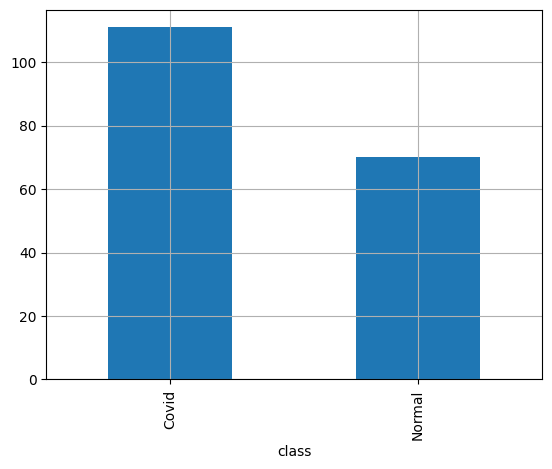

In [7]:
traindf = createdf(TRAIN_DIR)

In [8]:
traindf = removeduplicates(traindf)

(181, 3)


Data length 46
                                           file_path   class
0  /kaggle/input/covid19-image-dataset/Covid19-da...  Normal
1  /kaggle/input/covid19-image-dataset/Covid19-da...  Normal
2  /kaggle/input/covid19-image-dataset/Covid19-da...  Normal
3  /kaggle/input/covid19-image-dataset/Covid19-da...  Normal
4  /kaggle/input/covid19-image-dataset/Covid19-da...  Normal


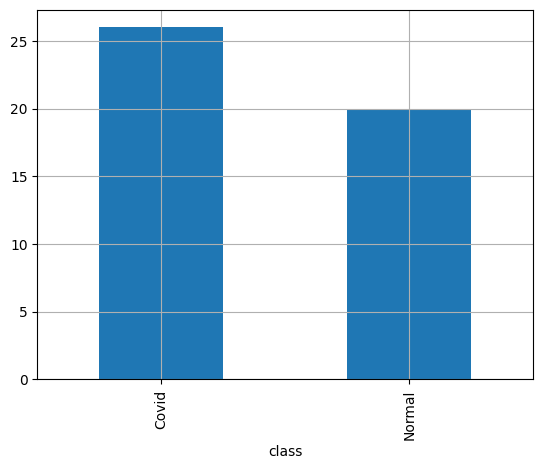

In [9]:
testdf = createdf(TEST_DIR)

In [10]:
traindf.loc[1, 'file_path']

'/kaggle/input/covid19-image-dataset/Covid19-dataset/train/Normal/014.jpeg'

In [12]:
def plotimg(path):
    img = plt.imread(path)
    plt.imshow(img)
    print('Shape of image - ',np.array(img).shape)
    plt.show()

def plotimgcv(img):
    plt.imshow(img)
    print('Shape of image - ',np.array(img).shape)
    plt.show()
    

Shape of image -  (2074, 2380, 3)


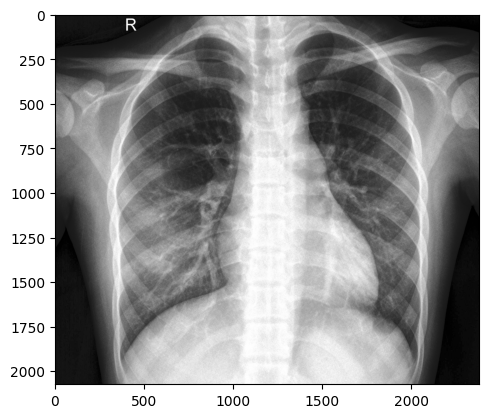

Class - Normal


In [102]:
# viz original images
plotimg(traindf.loc[1, 'file_path'])
print('Class -',traindf.loc[1, 'class'])

Shape of image -  (2382, 2746, 3)


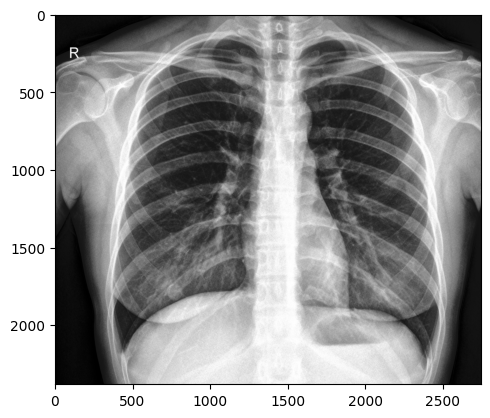

Class - Normal


In [103]:
plotimg(traindf.loc[18, 'file_path'])
print('Class -',traindf.loc[18, 'class'])

In [13]:
# unsharp masking 
def umasking(img):
    test=img.copy()
    smooth = cv2.GaussianBlur(test, (0, 0), 2.0)
    unsharp = cv2.addWeighted(test, 2, smooth, -1, 0)
    return unsharp

# histogram equalization
def histequal(img):
    test=img.copy()
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(test)
    return cl1

# https://stackoverflow.com/questions/12023958/what-does-cvnormalize-src-dst-0-255-norm-minmax-cv-8uc1
def preprocess(img):
    grayimage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_n = cv2.normalize(src=grayimage, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    imgup = umasking(img_n)
    grayimg = histequal(imgup)
    rgbimg = cv2.cvtColor(grayimg, cv2.COLOR_GRAY2RGB)
    return rgbimg

Shape of image -  (2382, 2746, 3)


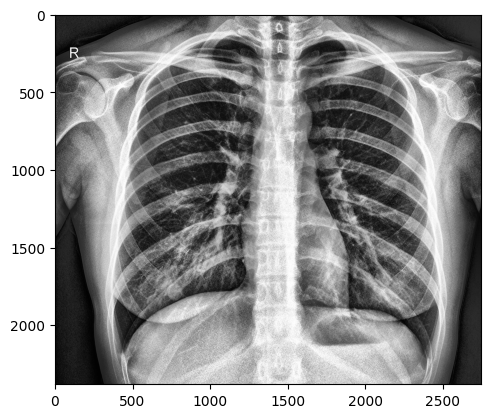

In [105]:
# test the preprocessing
img = cv2.imread(traindf.loc[18, 'file_path'], cv2.IMREAD_GRAYSCALE)
imgup = umasking(img)
imgup1 = histequal(imgup)
bgrimg = cv2.cvtColor(imgup1, cv2.COLOR_GRAY2BGR)
plotimgcv(bgrimg)

Shape of image -  (2382, 2746, 3)


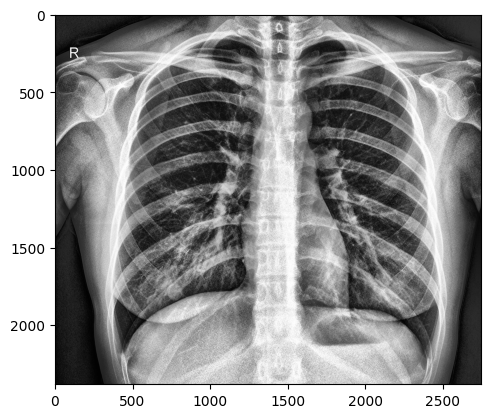

In [78]:
img = plt.imread(traindf.loc[18, 'file_path'])
img = preprocess(img)
plt.imshow(img)
print('Shape of image - ',np.array(img).shape)
plt.show()

In [14]:
# dataset parameters
CLASS_MODE = 'binary' 
TARGET_SIZE = (224,224)
EPOCHS = 5 
BATCH_SIZE = 6 

In [15]:
# preprocessing on each image
def create_datagen():
    return ImageDataGenerator(preprocessing_function = preprocess)
#                               rescale = 1./255,
#                               samplewise_center = True,
#                               samplewise_std_normalization = True)
#                             brightness_range=[0.2,1.2]) # brightness

In [16]:
#https://stackoverflow.com/questions/62662194/keras-imagedatagenerator-validation-split-not-selected-from-shuffled-dataset
# training
def create_train_gen(datagen, traindata):
    return datagen.flow_from_dataframe(
        traindata, 
#         directory=TRAIN_DIR,
        x_col='file_path', 
        y_col='class',
        class_mode=CLASS_MODE,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True
#         subset='training'
    )

In [17]:
def create_val_gen(datagen, val_data): 
    return datagen.flow_from_dataframe(
        val_data, 
        x_col='file_path', 
        y_col='class',
        class_mode=CLASS_MODE,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

In [18]:
# test
def create_test_gen(datagen): 
    return datagen.flow_from_dataframe(
        testdf, 
#         directory=TEST_DIR,
        x_col='file_path', 
        y_col='class',
        class_mode=CLASS_MODE,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
#         subset='validation'
    )

In [ ]:
# split data into train and validation sets, small data sets let us do this
trainsplit, valsplit = train_test_split(traindf, test_size=0.2, random_state=42)

In [19]:
# preprocessed images
data_generator = create_datagen()
train_gen = create_train_gen(data_generator, trainsplit)
val_gen = create_val_gen(data_generator, valsplit)
test_gen = create_test_gen(data_generator)

Found 181 validated image filenames belonging to 2 classes.
Found 46 validated image filenames belonging to 2 classes.
Found 46 validated image filenames belonging to 2 classes.


The model for MobileNet

Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 354ms/step - accuracy: 0.6055 - loss: 1.4668 - val_accuracy: 1.0000 - val_loss: 0.0308
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0353 - val_accuracy: 1.0000 - val_loss: 0.0056
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 284ms/step - accuracy: 0.9757 - loss: 0.0861 - val_accuracy: 1.0000 - val_loss: 0.0209
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 1.0000 - loss: 0.0198 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 295ms/step - accuracy: 0.9652 - loss: 0.0781 - val_accuracy: 0.9048 - val_loss: 0.2426
Found 46 validated image filenames belonging to 2 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.8627 - loss: 0.3140
Test Loss: 0.21365541219711304
Test Accuracy: 0.9130434989929199
Precision: 1.0
Recall: 0.8
F1-Score: 0.888888888888889
ROC AUC Score: 1.0


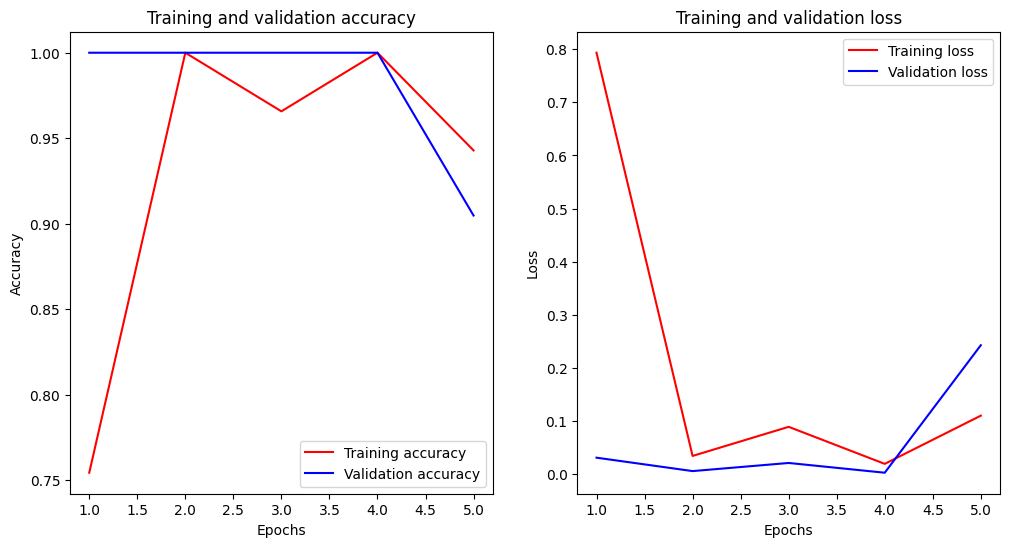

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.applications import MobileNet
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# how we define a MobileNet model
def build_model():
    base_model = MobileNet(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze layers in base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

model = build_model()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


# training
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=val_gen.n // BATCH_SIZE,
    callbacks=[ModelCheckpoint('/kaggle/working/model.keras', save_best_only=True)]
)


In [ ]:
# evaluate the model on the test set
y_true = test_gen.classes
y_pred = model.predict(test_gen)

# calculate and print metrics
loss, accuracy = model.evaluate(test_gen)
precision = precision_score(y_true, y_pred.round())
recall = recall_score(y_true, y_pred.round())
f1 = f1_score(y_true, y_pred.round())
roc_auc = roc_auc_score(y_true, y_pred)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC Score:", roc_auc)

# plot the training and validation accuracy/loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The model for Vgg

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7809 - loss: 52.5716 - val_accuracy: 0.9524 - val_loss: 4.9587
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 9.6746
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9972 - loss: 0.4272 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 1.0000 - loss: 5.7675e-30 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Found 46 validated image filenames belonging to 2 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00
Test Loss: 0.0
Test Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
ROC AUC Score: 1.0


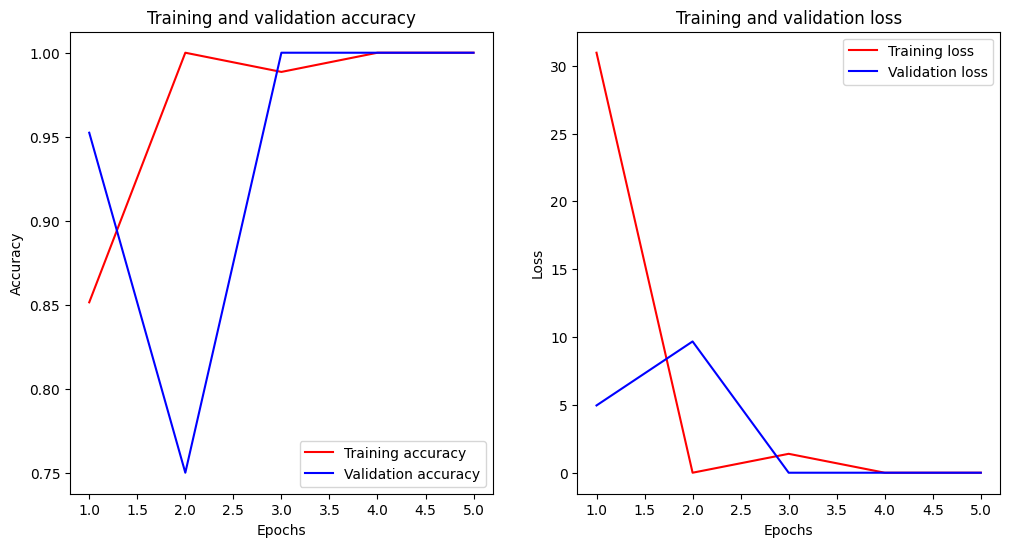

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.applications import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# how we define your VGG model
def build_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze layers in base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

# compile the model with our defined function
model = build_model()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


# train the model
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=val_gen.n // BATCH_SIZE,
    callbacks=[ModelCheckpoint('/kaggle/working/model.keras', save_best_only=True)]
)


In [ ]:
# evaluate the model on the test set
y_true = test_gen.classes
y_pred = model.predict(test_gen)

# calculate and print metrics
loss, accuracy = model.evaluate(test_gen)
precision = precision_score(y_true, y_pred.round())
recall = recall_score(y_true, y_pred.round())
f1 = f1_score(y_true, y_pred.round())
roc_auc = roc_auc_score(y_true, y_pred)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC Score:", roc_auc)

# plot the training and validation accuracy/loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The model for Resnet50

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 892ms/step - accuracy: 0.7719 - loss: 0.9394 - val_accuracy: 1.0000 - val_loss: 0.0368
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 755ms/step - accuracy: 0.9437 - loss: 0.0791 - val_accuracy: 1.0000 - val_loss: 0.0128
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0153
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 771ms/step - accuracy: 0.9858 - loss: 0.0280 - val_accuracy: 0.9762 - val_loss: 0.0189
Found 46 validated image filenames belonging to 2 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 912ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 606ms/step - accuracy: 0.9657 - loss: 0.0256
Test Loss: 0.016577674075961113
Test Accuracy: 0.97826087474823
Precision: 1.0
Recall: 0.95
F1-Score: 0.9743589743589743
ROC AUC Score: 1.0


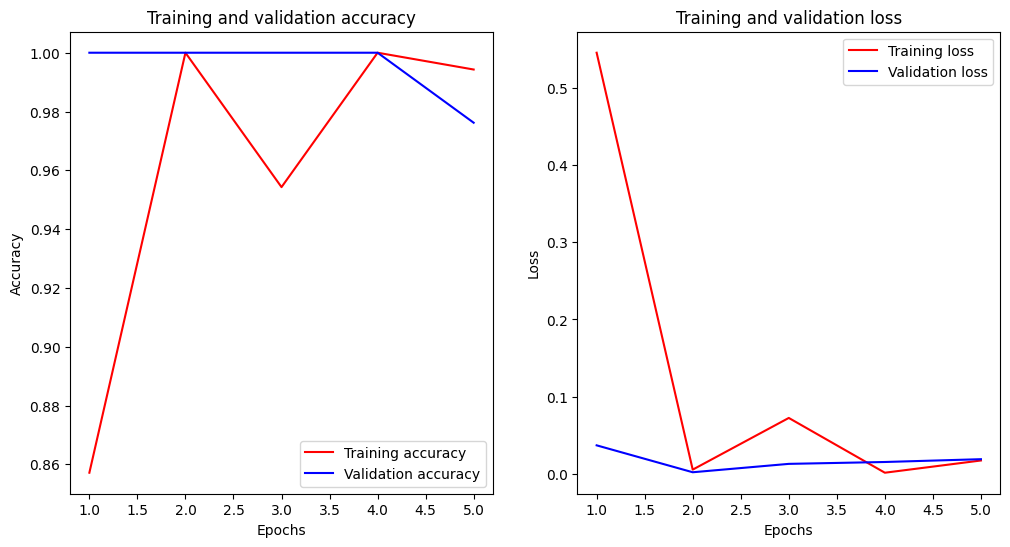

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# how we define your ResNet model
def build_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze layers in base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

# compile the model using the above function
model = build_model()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=val_gen.n // BATCH_SIZE,
    callbacks=[ModelCheckpoint('/kaggle/working/model.keras', save_best_only=True)]
)


In [ ]:

# evaluate the model with our test set
y_true = test_gen.classes
y_pred = model.predict(test_gen)

# calculate and print metrics
loss, accuracy = model.evaluate(test_gen)
precision = precision_score(y_true, y_pred.round())
recall = recall_score(y_true, y_pred.round())
f1 = f1_score(y_true, y_pred.round())
roc_auc = roc_auc_score(y_true, y_pred)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC Score:", roc_auc)

# plot the training and validation accuracy/loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The model for DenseNet

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5962 - loss: 3.0502 - val_accuracy: 0.9762 - val_loss: 0.0531
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.8333 - loss: 0.3355 - val_accuracy: 1.0000 - val_loss: 0.0421
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 817ms/step - accuracy: 0.9242 - loss: 0.3547 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 0.0130
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 818ms/step - accuracy: 0.9226 - loss: 0.1667 - val_accuracy: 1.0000 - val_loss: 9.1308e-04
Found 46 validated image filenames belonging to 2 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 572ms/step - accuracy: 1.0000 - loss: 7.9416e-04
Test Loss: 0.0008146121399477124
Test Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
ROC AUC Score: 1.0


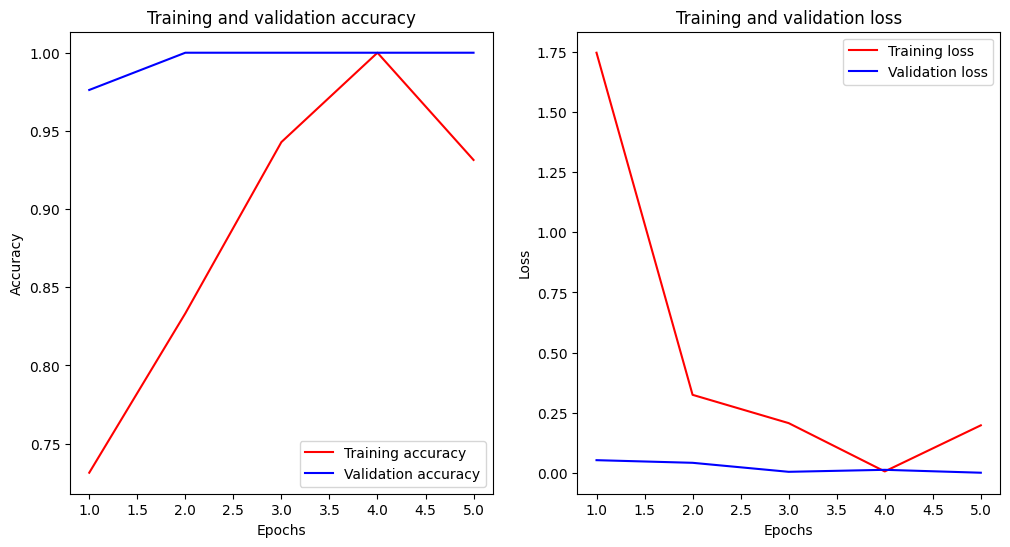

In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# how we defined your DenseNet model
def build_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze layers in base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

# compile the model with the above function
model = build_model()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


# training the model
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=val_gen.n // BATCH_SIZE,
    callbacks=[ModelCheckpoint('/kaggle/working/model.keras', save_best_only=True)]
)



In [ ]:
# evaluate the model on the test set
y_true = test_gen.classes
y_pred = model.predict(test_gen)

# calculate and print the metrics
loss, accuracy = model.evaluate(test_gen)
precision = precision_score(y_true, y_pred.round())
recall = recall_score(y_true, y_pred.round())
f1 = f1_score(y_true, y_pred.round())
roc_auc = roc_auc_score(y_true, y_pred)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC Score:", roc_auc)

# plot the training and validation accuracy/loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()